In [ ]:
#|default_exp fisher

By Fred Guth

One-sentence summary: Create a callback that calculates the Fisher Information in the weights and uses it to speedup learning.

## Motivation

During training, a model stores information about the training dataset in its weights, $I[D;W]$ (mutual information between $D$ and $W$).  Ideally, it would only store information that is useful for the task, but most of what is stored in the weights is information about the input that does not relate to the task: $I[X;W]>>I[Y;W]$.

Knowing how much information our model retains during training can can be useful for:
* checking if the model is overfitting;
* updating the learning rate
* creating a regularization term for the loss

To calculate the Shannon information in the weights, we would need to know the true distribution $p(x,y;\theta)$ that we are estimating with our model $q(x,y;w)$. Still, we can calculate the Fisher Information in the weights, which is a lower bound for the Shannon Information.


## A Simple Baseline

In [ ]:
#|export
from __future__ import annotations
from wwf.utils import state_versions
from nbdev import show_doc
import random,math,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from torch import tensor,nn,optim
import torch.nn.functional as F
from torch.distributions import Categorical
import torchvision.transforms.functional as TF
from datasets import load_dataset
import datasets
import time
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from torcheval.metrics import MulticlassAccuracy,Mean
from tqdm.auto import tqdm

In [ ]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
from IPython.core.debugger import set_trace
from fastcore.test import test_close
import lovely_tensors as lt
lt.monkey_patch()
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)
state_versions(['miniai', 'fastcore', 'torch'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `miniai`, `fastcore`, and `torch` currently running at the time of writing this:
* `miniai` : 0.0.1 
* `fastcore` : 1.5.27 
* `torch` : 1.12.1 
---

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=6)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#|export
def lin(ni, nf, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Linear(ni, nf, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [ ]:
lin(784,392)

Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): ReLU()
)

In [ ]:
def_device

'cuda'

In [ ]:
#|export
def get_simple_model(act=nn.ReLU, nhs=None, norm=None):
    m = 28*28
    if nhs is None: nhs = [m//(2**i) for i in range(6)] # [784, 392, 196, 98, 49, 24]
    layers = [lin(nhs[i], nhs[i+1], act, norm) for i in range(len(nhs)-1)]
    return nn.Sequential(nn.Flatten(),*layers, lin(nhs[-1],10, act=None, norm=False, bias=True)).to(def_device)

In [ ]:
get_simple_model(nhs=[784,50])

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=50, out_features=10, bias=True)
  )
)

accuracy,loss,epoch,train
0.426,2.022,0,train
0.552,1.759,0,eval


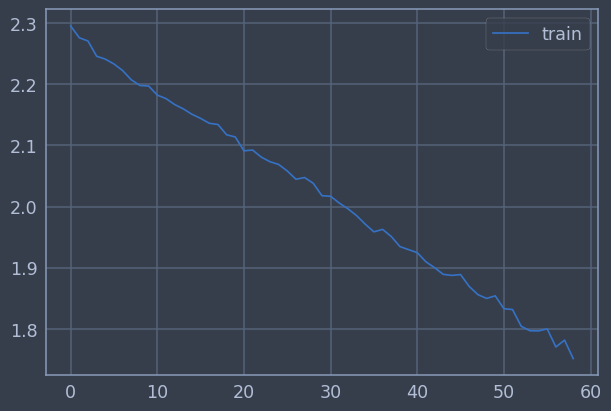

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(get_simple_model(nhs=[784,50]), dls, F.cross_entropy, lr=0.02, cbs=cbs)
learn.fit(1)

accuracy,loss,epoch,train
0.167,2.188,0,train
0.248,1.788,0,eval


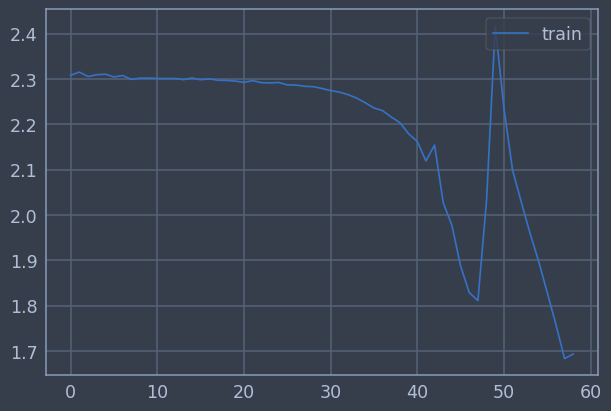

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(get_simple_model(), dls, F.cross_entropy, lr=5e-1, cbs=cbs)
learn.fit(1)

In [ ]:
get_model()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

accuracy,loss,epoch,train
0.770,0.652,0,train
0.798,0.529,0,eval


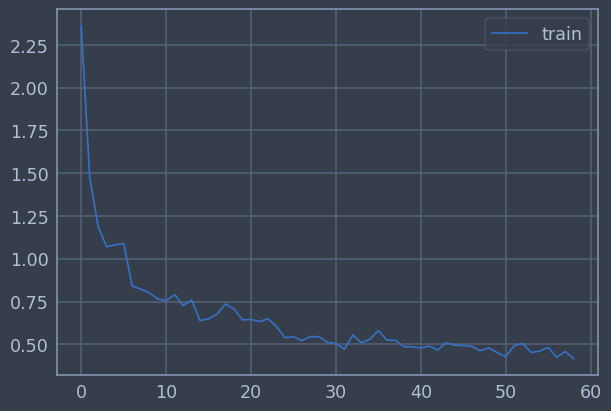

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(get_model(act_gr, norm=nn.BatchNorm2d).apply(iw), dls, F.cross_entropy, lr=5e-1, cbs=cbs)
learn.fit(1)

## Fisher Information definition

Let $D$ be a random variable sampled from distribution $p(D|W^{*})$ parametrized by the unknown ${W^*}:\mathbb{R}^p = \begin{bmatrix} w_1 & w_2 & \dots & w_p\end{bmatrix}^\textsf{T}.$  
As a shortcut notation, $p(\cdot; W^{*}) = p_{w^{*}}=p_{*}$.

Let the scalar field $p_w: \mathbb{R}^p \to \mathbb{R}$ be a model of the true distribution $p_*$.

The **Fisher Information** (aka *Fisher Information Matrix* or *FIM*) of the model $p_w$ w.r.t its vector parameter $W$, $F(W)$ is:

\begin{align}
F(W)        &= -\mathbb{E}_{D\sim p_*} \left[ \frac{\partial^2}{\partial w^2} \log p_w(D) \right] \\
[F(W)]_{i,j}  &= -\mathbb{E}_{D\sim p_*} \left[ \nabla_{w_i} \log p_w(D) \cdot \nabla_{w_j} \log p_w(D)^{\textsf{T}} \right] 
\end{align}

The Fisher information measures the overall sensitivity of the functional relationship $p$ to changes of $W$ by weighting the sensitivity at each potential outcome $D$ w.r.t $p_{w}(D)$ @{maarten:2017}

## The Fisher information of a DNN wrt its weigths
In DL, we are given a dataset $D=\{(x,y)\}^{(n)}_{i=1}$ sampled from the distribution we want to model with $p_w$.  

The **Fisher information matrix** $F \in \mathbb{R}^{N \times N}$ of a DNN with learnable parameter $W \in \mathbb{R}^{N}$ is the matrix:
	\begin{align}
		[F(W)]_{i,j} = -\mathbb{E}_{x\sim p_*} \left[ \frac{\partial^2}{\partial w^2} \log p_w(y|x) \right] 
	\end{align}

## Cross-Entropy Loss and Fisher Information
The model $p_w$ is commonly obtained by minimizing the cross-entropy loss, $H(p_*,p_w)$, which is the average number of bits needed to encode data coming from a source D with distribution $p_*(D)$ when using model $p_w(D)$.
    \begin{align}
     \mathscr{L}=H(p_*,p_w)[D]=-\mathbb{E}_{x \sim p_*}\log p_w(y|x)
    \end{align}

### The Hessian of the Cross-Entropy Loss is equivalent to the Fisher Information Matrix:
From: https://agustinus.kristia.de/techblog/2018/03/14/natural-gradient/

The hessian ($\mathbb{H}$) of the cross-entropyvloss, $H(p_*,p_w)$, is:
\begin{align}
    \mathbb{H}(\mathscr{L}) &= \mathbb{H} H(p_*,p_w) \\
    &=\nabla_{W}^2 H[p_*,p_w] =  \nabla_{W}^2 \left[-\mathbb{E}_{x\sim p_*} \log p_W(y|x)\right] \\
    &= - \mathbb{E}_{x\sim p_*}  \nabla_{W}^2 \log p_w(y|x) \\
    &= F(W)
\end{align}

The hessian of the cross-entropy loss is the fisher information. 

### So what?

$F(W)$ measures the curvature of the loss function for a certain $w$; i.e. $F$ indicates if the $w$ found is in a sharp minima region or a flat minima region.
If $W$ is a minimum in a sharp minima region, small changes in $W$ result in larger changes in the loss; if is in a flat minima region, small changes in $W$ result in smaller changes in the loss. 
![./images/flat-minima2.png](./images/flat-minima2.png)

## Fisher Information Approximation

Calculating the fisher information is $O(p^2)$, where $p$ is the number of parameters of the model, which in DNNs can be hundreds of thousands or even millions. 

### Layer-wise block-diagonal approximation
A common simplification of the **Fisher Information Matrix (FIM)** is to reduce it to the diagonal:
\begin{align}
	[F(W)]_{i} &:= \mathbb{E}_{x \sim p_*} \left[ \nabla_{w_i} \log p_{w}(y|x)^2 \right] \tag{diag F}
\end{align}

### Mini-batch expectation approximation

We approximate the expectation over the input data distribution $\mathbb{E}_{x \sim p_*}$ using the empirical expectation over a mini-batch $\mathbb{E}_{{x}^b \sim D}$. This enables estimation of $F$ ion the same backward pass of the Stochastic Gradient learning.

## Fisher  Information Callback

Let's create a Callback to calculate the fisher information in the weights of our model.


We will approximate the FIM with the diagonal and sampling from target instead of the model output, aka empirical Fisher.

In [ ]:
#|export
class FisherCB(TrainCB):
    def before_fit(self):
        self.learn.fisher = self
        self.Fs = []
        self.Iy = []
        self.FIM = torch.zeros_like(torch.cat([p.data.unsqueeze(0).flatten() for p in self.learn.model.parameters() if p.requires_grad]))
        self.i = 0
    def after_batch(self):
        if self.learn.model.training: self.Iy.append([v.compute() for k,v in self.learn.metrics.all_metrics.items() if k=='accuracy'][0])
    def backward(self):
        self.learn.loss.backward()
        if self.learn.model.training:
            F = torch.cat([(p.grad**2).unsqueeze(0).flatten() for p in self.learn.model.parameters() if (hasattr(p,'grad'))])
            self.FIM += F
            self.Fs.append(to_cpu(F))
            self.i += 1

accuracy,loss,epoch,train
0.550,1.240,0,train
0.692,0.816,0,eval


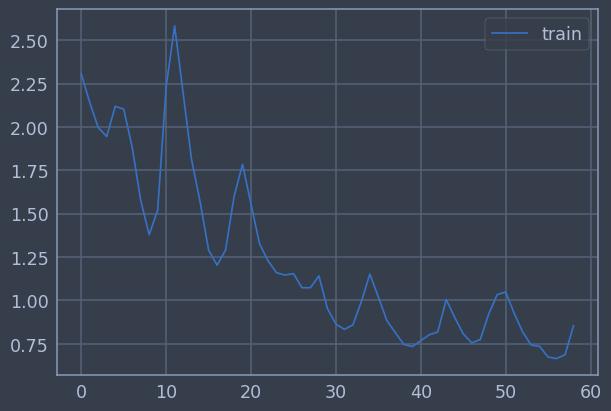

In [ ]:
set_seed(42)
fcb=FisherCB()
iw = partial(init_weights, leaky=0.1)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, fcb, ProgressCB(plot=True)]
learn = Learner(get_simple_model(nhs=[28*28,50]), dls, F.cross_entropy, lr=5e-1, cbs=cbs)
learn.fit(1)

In [ ]:
fcb.FIM.sum()/fcb.i

tensor cuda:0 1.991

In [ ]:
#|export
from torcheval.metrics import Metric
class FisherInfo(Metric[torch.Tensor]):
    def __init__(self, device = None, fisher_cb= None):
        super().__init__(device=device)
        self.fcb = fisher_cb
        self.fisher_info = 0
    def update(self, input: torch.Tensor, target: torch.Tensor): return self
    def compute(self):
        self.fisher_info = (self.fcb.FIM.sum()/self.fcb.i) if (self.fcb.FIM is not None and self.fcb.i>0) else 0
        return self.fisher_info
    def merge_state(self): return self
    @property
    def value(self):
        return self.fisher_info
    @property
    def name(self): return 'fisher'

accuracy,fisher,loss,epoch,train
0.550,1.991,1.240,0,train
0.692,1.991,0.816,0,eval


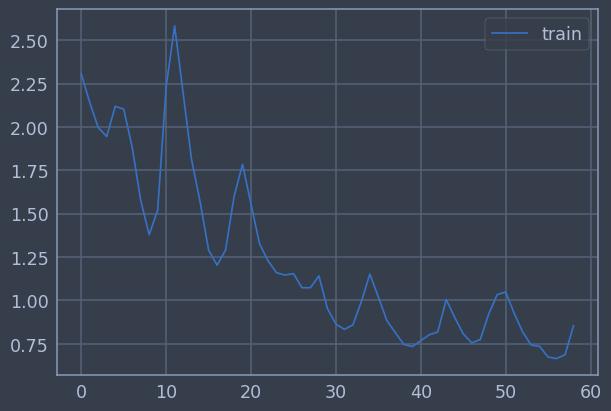

In [ ]:
set_seed(42)
fcb = FisherCB()

metrics = MetricsCB(accuracy=MulticlassAccuracy(), fisher=FisherInfo('cpu',fcb))
cbs = [DeviceCB(),fcb, metrics, ProgressCB(plot=True)]
learn = Learner(get_simple_model(nhs=[28*28,50]), dls, F.cross_entropy, lr=5e-1, cbs=cbs)
learn.fit(1)

In [ ]:
list(learn.metrics.all_metrics.items())[:-1]

[('accuracy',
  <torcheval.metrics.classification.accuracy.MulticlassAccuracy>),
 ('fisher', <__main__.FisherInfo>)]

In [ ]:
l = [(10,11,12,13), (20,21,22,23)]
z = zip(*l)
r = list(z)
r

[(10, 20), (11, 21), (12, 22), (13, 23)]

In [ ]:
#|export
from fastprogress import progress_bar,master_bar
class ProgressMetricsCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self):
        self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
        self.mbar.names=[k for k,v in self.learn.metrics.all_metrics.items()]
        if hasattr(self.learn, 'metrics'): self.learn.metrics._log = self._log
        self.metrics=[]
    def _log(self, d): self.mbar.write(str(d))
    def before_epoch(self): self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.mbar)
    def after_batch(self):
        if self.plot and hasattr(self.learn, 'metrics') and self.training:
            self.metrics.append([v.compute().detach().cpu() for k,v in self.learn.metrics.all_metrics.items()])
            self.mbar.update_graph([[fc.L.range(m),m] for m in zip(*self.metrics)])

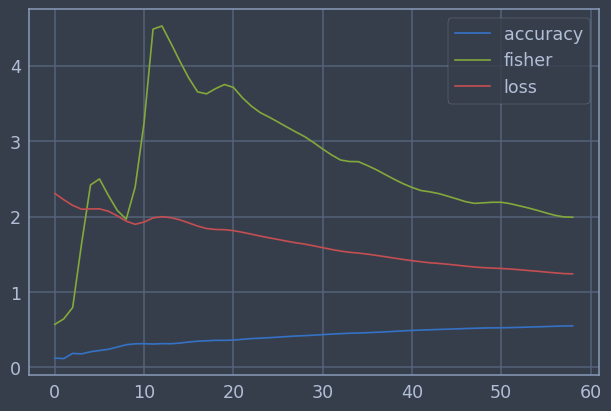

In [ ]:
set_seed(42)
fcb = FisherCB()
metrics = MetricsCB(accuracy=MulticlassAccuracy(), fisher=FisherInfo('cpu',fcb))
cbs = [DeviceCB(),fcb, metrics, ProgressMetricsCB(plot=True)]
learn = Learner(get_simple_model(nhs=[28*28,50]), dls, F.cross_entropy, lr=5e-1, cbs=cbs)
learn.fit(1)

## Using Fisher to Calculate the Natural Gradient

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params =list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd
        
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

accuracy,loss,epoch,train
0.601,1.159,0,train
0.684,0.868,0,eval
0.745,0.715,1,train
0.758,0.656,1,eval
0.786,0.613,2,train
0.794,0.583,2,eval


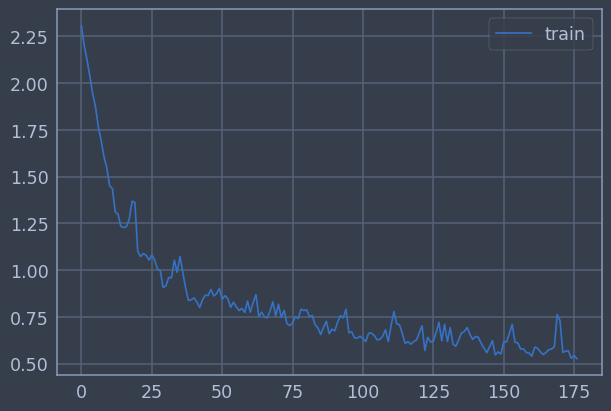

In [ ]:
set_seed(42)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(),fcb, metrics, ProgressCB(plot=True)]
learn = TrainLearner(get_simple_model(nhs=[28*28,50]), dls, F.cross_entropy, lr=0.2, cbs=cbs, opt_func=SGD)
learn.fit(3)

accuracy,loss,epoch,train
0.488,17789.471,0,train
0.614,2544.913,0,eval
0.677,2009.469,1,train
0.730,998.953,1,eval
0.720,967.799,2,train
0.736,729.566,2,eval


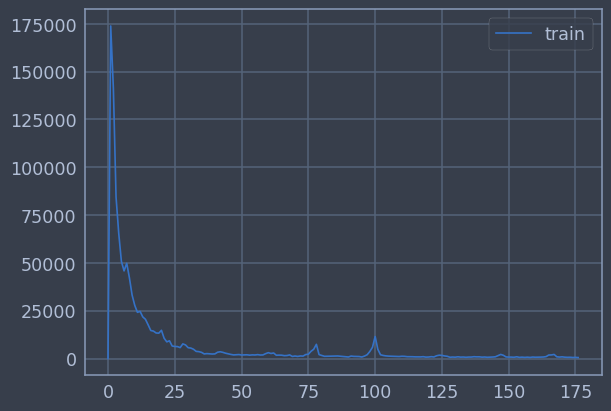

In [ ]:
class Natural(SGD):
    def __init__(self, params, lr, wd=0., eps=1e-4):
        super().__init__(params, lr=lr, wd=wd)
        self.eps = eps
        self.i = 0
    def opt_step(self, p):
        self.i+=1
        if not hasattr(p, 'grad2'): p.grad2 = torch.zeros_like(p.grad.data)
        p.grad2 += p.grad ** 2
        p -= self.lr * (p.grad / ((p.grad2/self.i) + self.eps))

set_seed(42)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(),fcb, metrics, ProgressCB(plot=True)]
learn = TrainLearner(get_simple_model(nhs=[28*28,50]), dls, F.cross_entropy, lr=0.2, cbs=cbs, opt_func=Natural)
learn.fit(3)

In [ ]:
#|export
class Natural(SGD):
    def __init__(self, params, lr, wd=0., eps=5e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.eps = eps
        self.i = 0
    def opt_step(self, p):
        self.i+=1
        if not hasattr(p, 'grad2'): p.grad2 = torch.zeros_like(p.grad.data)
        p.grad2 += p.grad ** 2
        p -= self.lr * (p.grad / ((p.grad2/self.i) + self.eps))

set_seed(42)

accuracy,loss,epoch,train
0.352,99212.016,0,train
0.581,16352.028,0,eval
0.672,7523.905,1,train
0.734,4359.441,1,eval
0.736,3782.964,2,train
0.762,3470.804,2,eval


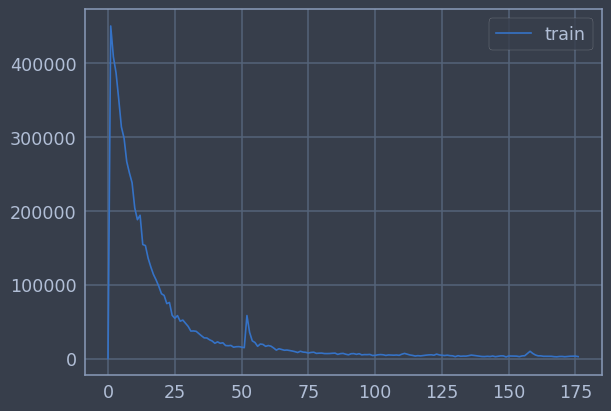

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(),fcb, metrics, ProgressCB(plot=True)]
learn = TrainLearner(get_simple_model(nhs=[28*28,50]), dls, F.cross_entropy, lr=0.2, cbs=cbs, opt_func=Natural)
learn.fit(3)

## Information Plane

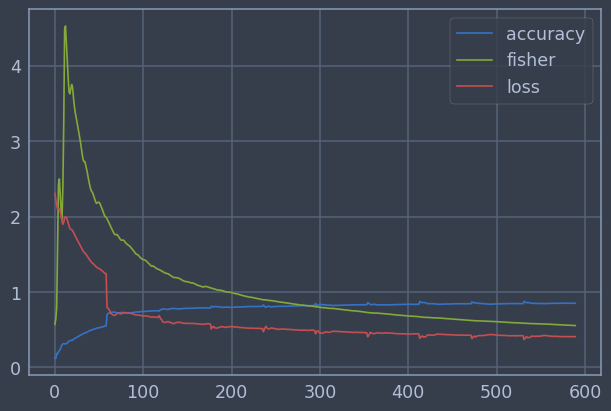

In [ ]:
set_seed(42)
fcb = FisherCB()
metrics = MetricsCB(accuracy=MulticlassAccuracy(), fisher=FisherInfo('cpu',fcb))
cbs = [DeviceCB(),fcb, metrics, ProgressMetricsCB(plot=True)]
learn = Learner(get_simple_model(nhs=[28*28,50]), dls, F.cross_entropy, lr=5e-1, cbs=cbs)
learn.fit(10)

In [ ]:
Fs=torch.stack(fcb.Fs)
Fmean0 = Fs.mean(0)
Fstd0 = Fs.std(0)
Fmean1 = Fs.mean(1)
Fstd1 = Fs.std(1)
Fsum1 = Fs.sum(1)
Fmean0, Fstd0, Fmean1, Fstd1, Fsum1

(tensor[39760] x∈[0., 0.008] μ=1.395e-05 σ=0.000,
 tensor[39760] x∈[0., 0.055] μ=6.329e-05 σ=0.001,
 tensor[590] x∈[9.413e-07, 0.000] μ=1.395e-05 σ=2.688e-05,
 tensor[590] x∈[4.618e-06, 0.010] μ=0.000 σ=0.001,
 tensor[590] x∈[0.037, 18.107] μ=0.554 σ=1.069)

In [ ]:
Fmean0.sum(),fcb.FIM.sum()/fcb.i

(tensor 0.554, tensor cuda:0 0.554)

<matplotlib.legend.Legend>

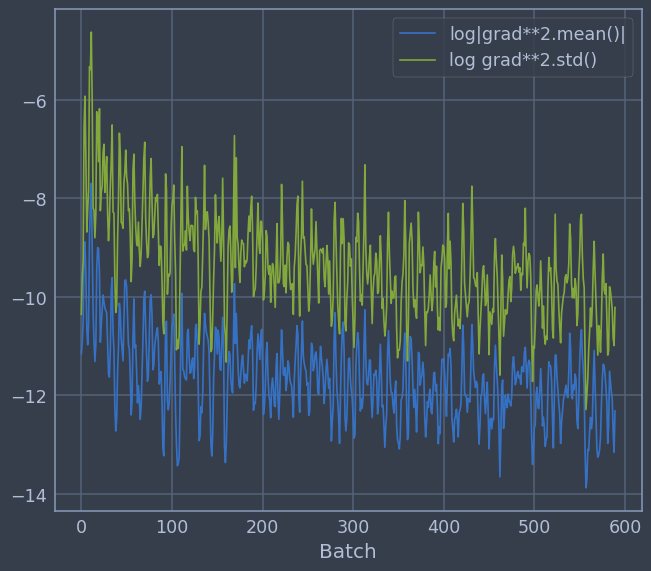

In [ ]:
x_list = range(len(Fsum1))
plt.plot(x_list, Fmean1.log(), x_list, Fstd1.log())
plt.xlabel ('Batch')
plt.legend([r'log|grad**2.mean()|', r'log grad**2.std()'])

In [ ]:
Fsqrtmean1 = Fs.sqrt().mean(1)
Fsqrtstd1 = Fs.sqrt().std(1)
Fsqrtmean1.shape

torch.Size([590])

<matplotlib.legend.Legend>

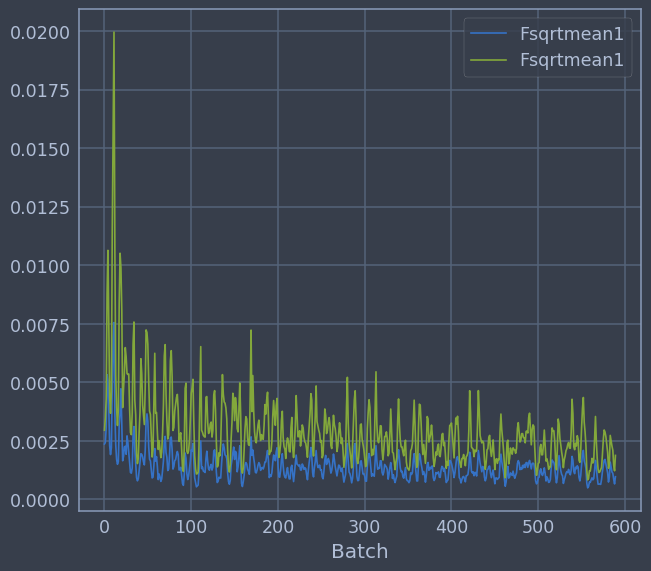

In [ ]:
x_list = range(len(Fsqrtmean1))
plt.plot(x_list, Fsqrtmean1, x_list, Fsqrtstd1)
plt.xlabel ('Batch')
plt.legend([r'Fsqrtmean1', r'Fsqrtmean1'])

<matplotlib.legend.Legend>

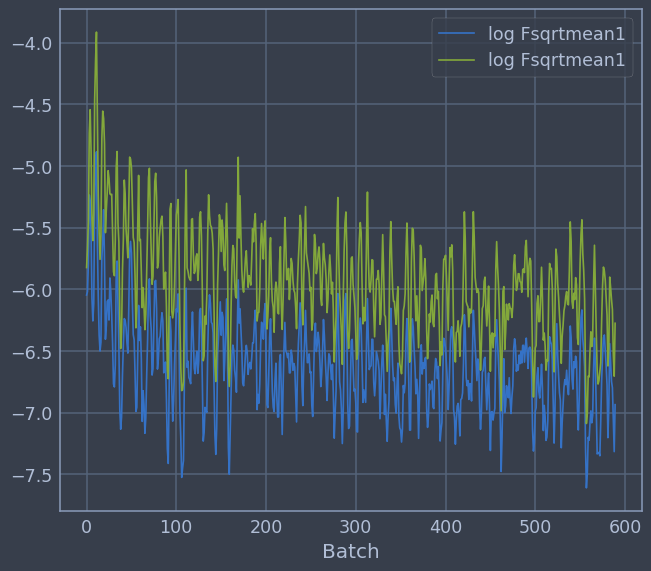

In [ ]:
x_list = range(len(Fsqrtmean1))
plt.plot(x_list, Fsqrtmean1.log(), x_list, Fsqrtstd1.log())
plt.xlabel ('Batch')
plt.legend([r'log Fsqrtmean1', r'log Fsqrtmean1'])

In [ ]:
tmp = [ Fsum1[0:i+1].sum()/(i+1) for i,_ in enumerate(x_list)]

Text(0, 0.5, 'Fisher Information - I(D;W)')

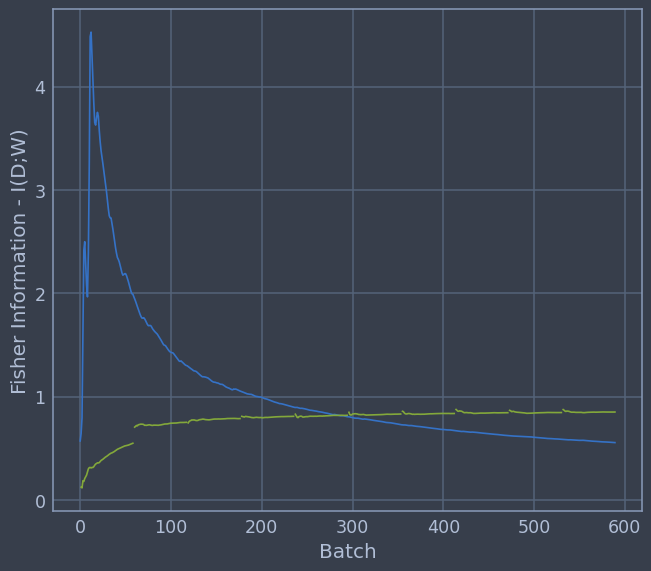

In [ ]:
plt.plot(x_list, [ Fsum1[0:i+1].sum()/(i+1) for i,_ in enumerate(x_list)])
plt.plot(x_list, fcb.Iy)
plt.xlabel('Batch')
plt.ylabel('Fisher Information - I(D;W)')

Text(0.5, 1.0, 'Accuracy ($I_Y$) vs. Fisher Information ($I_X$)')

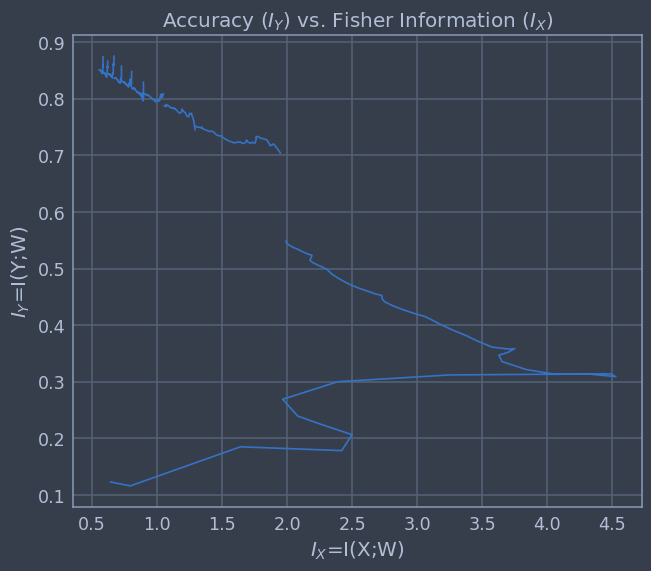

In [ ]:
plt.plot([ Fsum1[0:i+1].sum()/(i+1) for i,_ in enumerate(x_list)], fcb.Iy)
plt.xlabel(r'$I_X$=I(X;W)')
plt.ylabel(r'$I_Y$=I(Y;W)')
plt.title(r'Accuracy ($I_Y$) vs. Fisher Information ($I_X$)')

<matplotlib.legend.Legend>

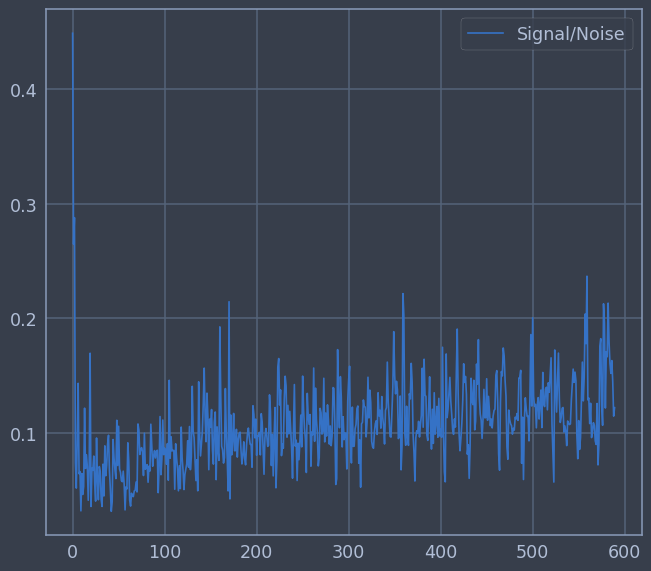

In [ ]:
plt.plot(x_list, Fmean1/Fstd1)
plt.legend(['Signal/Noise'])

In [ ]:
def split_FIM(F, model, names=False):
    if names:
        return [{n:F.cpu()[:len(p.flatten())]} for n,p in learn.model.named_parameters()]
    else:
        return [F.cpu()[:len(p.flatten())] for n,p in learn.model.named_parameters()]

In [ ]:
split_FIM(fcb.FIM, learn.model)

[tensor[39200] x∈[0., 0.068] μ=0.006 σ=0.010,
 tensor[50] x∈[0., 0.000] μ=3.748e-05 σ=6.518e-05,
 tensor[500] x∈[0., 0.000] μ=0.000 σ=9.881e-05,
 tensor[10] x∈[0., 3.930e-06] μ=5.194e-07 σ=1.245e-06 [0., 0., 3.203e-12, 1.287e-10, 2.434e-09, 8.663e-10, 9.204e-09, 1.729e-07, 1.079e-06, 3.930e-06]]

In [ ]:
split_FIM(fcb.FIM, learn.model, names=False)

[tensor[39200] x∈[0., 0.068] μ=0.006 σ=0.010,
 tensor[50] x∈[0., 0.000] μ=3.748e-05 σ=6.518e-05,
 tensor[500] x∈[0., 0.000] μ=0.000 σ=9.881e-05,
 tensor[10] x∈[0., 3.930e-06] μ=5.194e-07 σ=1.245e-06 [0., 0., 3.203e-12, 1.287e-10, 2.434e-09, 8.663e-10, 9.204e-09, 1.729e-07, 1.079e-06, 3.930e-06]]

In [ ]:
a = [split_FIM(F,learn.model, names=False) for F in fcb.Fs]
a[0]

[tensor[39200] x∈[0., 0.000] μ=1.396e-05 σ=2.984e-05,
 tensor[50] x∈[0., 4.682e-09] μ=4.175e-10 σ=8.524e-10,
 tensor[500] x∈[0., 1.007e-07] μ=6.655e-09 σ=1.456e-08,
 tensor[10] x∈[0., 6.200e-12] μ=6.200e-13 σ=1.961e-12 [0., 0., 0., 0., 0., 0., 0., 0., 0., 6.200e-12]]

In [ ]:
layers= list(zip(*[split_FIM(F,learn.model) for F in fcb.Fs]))

In [ ]:
[torch.stack(layer) for layer in layers]

[tensor[590, 39200] n=23128000 x∈[0., 0.014] μ=9.711e-06 σ=7.445e-05,
 tensor[590, 50] n=29500 x∈[0., 0.000] μ=6.352e-08 σ=2.893e-06,
 tensor[590, 500] n=295000 x∈[0., 0.000] μ=1.935e-07 σ=5.563e-06,
 tensor[590, 10] n=5900 x∈[0., 3.773e-06] μ=8.804e-10 σ=5.112e-08]

In [ ]:
def split_Fs(Fs:list):
    layers = list(zip(*[split_FIM(F,learn.model) for F in Fs]))
    return [torch.stack(layer) for layer in layers]

In [ ]:
split_Fs(fcb.Fs)

[tensor[590, 39200] n=23128000 x∈[0., 0.014] μ=9.711e-06 σ=7.445e-05,
 tensor[590, 50] n=29500 x∈[0., 0.000] μ=6.352e-08 σ=2.893e-06,
 tensor[590, 500] n=295000 x∈[0., 0.000] μ=1.935e-07 σ=5.563e-06,
 tensor[590, 10] n=5900 x∈[0., 3.773e-06] μ=8.804e-10 σ=5.112e-08]

In [ ]:
split_Fs(fcb.Fs)[0]

tensor[590, 39200] n=23128000 x∈[0., 0.014] μ=9.711e-06 σ=7.445e-05

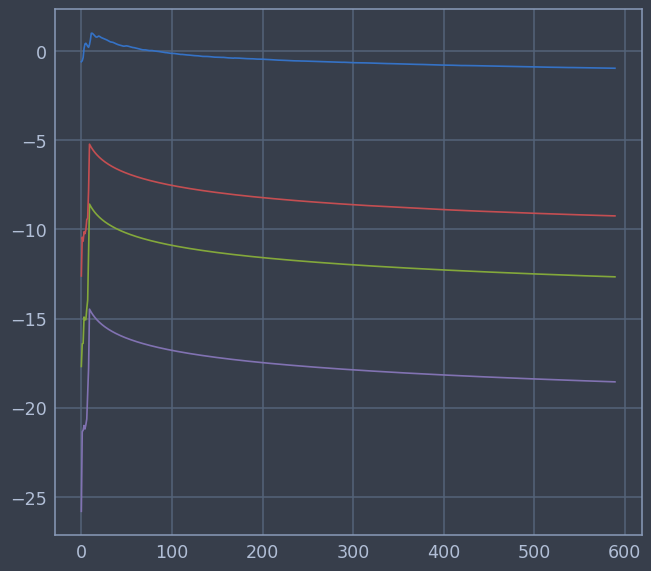

In [ ]:
# fig, ax = plt.subplots(2, 1)
for F in split_Fs(fcb.Fs):
    plt.plot(x_list, [ torch.log(F[0:i+1].sum()/(i+1)) for i,_ in enumerate(x_list)])
plt.show()

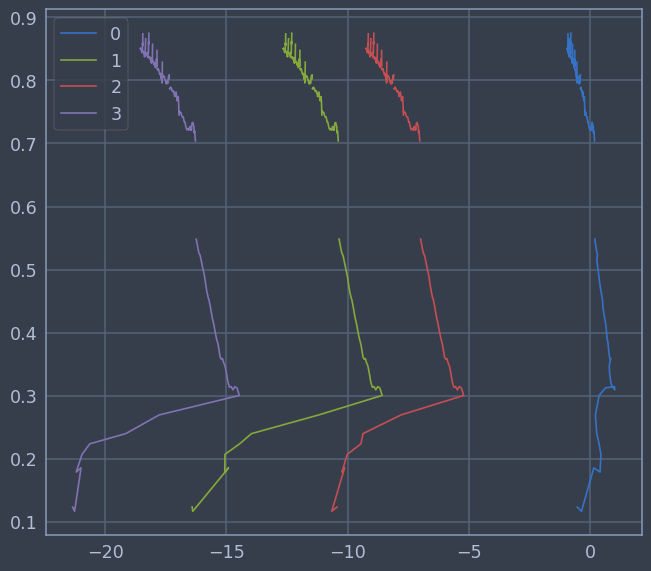

In [ ]:
# fig, ax = plt.subplots(2, 1)
for F in split_Fs(fcb.Fs):
    plt.plot([ torch.log(F[0:i+1].sum()/(i+1)) for i,_ in enumerate(x_list)], fcb.Iy)

plt.legend(range(4))
plt.show()

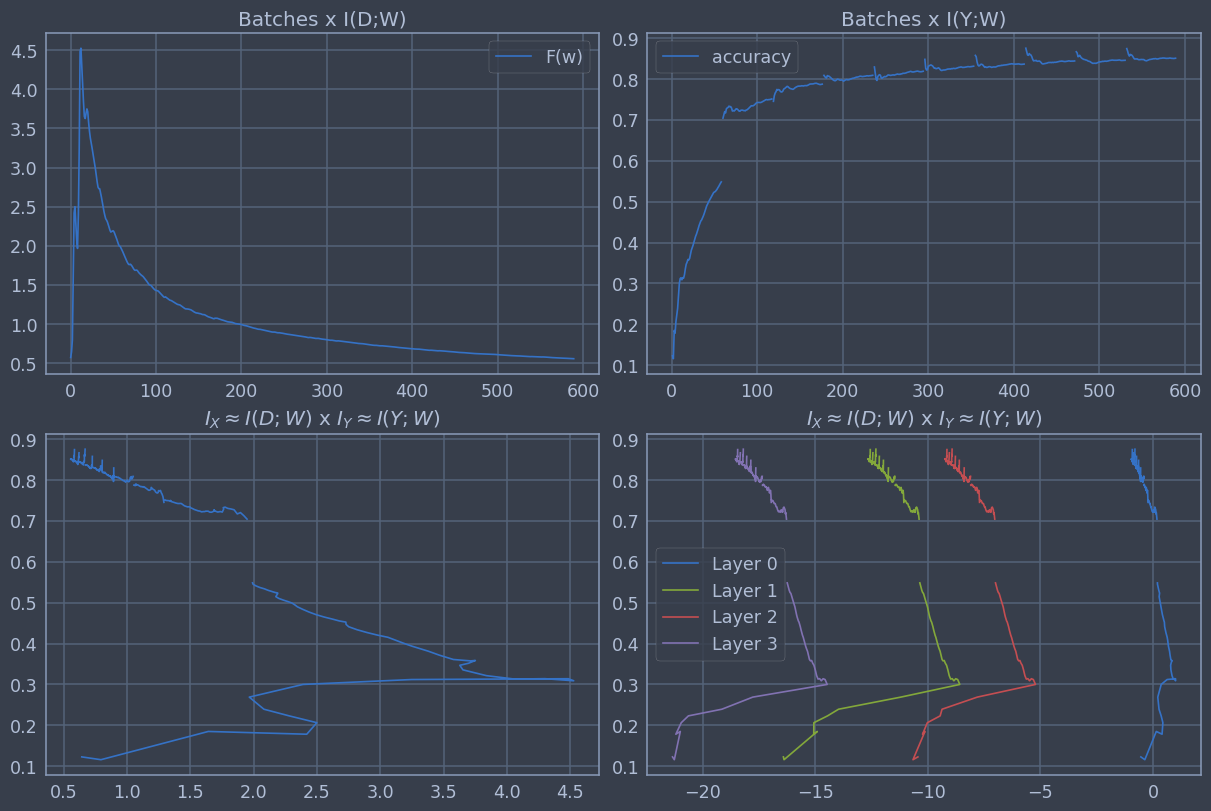

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.tight_layout()
ax[0,0].plot(x_list, [ Fsum1[0:i+1].sum()/(i+1) for i,_ in enumerate(x_list)])
ax[0,0].set_title('Batches x I(D;W)')
ax[0,1].plot(x_list, fcb.Iy)
ax[0,1].set_title('Batches x I(Y;W)')
ax[0,0].legend([r'F(w)'])
ax[0,1].legend([r'accuracy'])
ax[1,0].plot([ Fsum1[0:i+1].sum()/(i+1) for i,_ in enumerate(x_list)], fcb.Iy)
ax[1,0].set_title(r'$I_X \approx I(D;W)$ x $I_Y \approx I(Y;W)$')
for F in split_Fs(fcb.Fs):
    ax[1,1].plot([ torch.log(F[0:i+1].sum()/(i+1)) for i,_ in enumerate(x_list)], fcb.Iy)
ax[1,1].legend(['Layer '+str(i) for i in range(4)])
ax[1,1].set_title(r'$I_X \approx I(D;W)$ x $I_Y \approx I(Y;W)$')
plt.show()

In [ ]:
# import torch.nn.functional as F
# act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
# astats = ActivationStats(fc.risinstance(GeneralRelu))
# iw = partial(init_weights, leaky=0.1)

# fcb = FisherCB()
# metrics = MetricsCB(accuracy=MulticlassAccuracy(), fisher=FisherInfo('cpu',fcb))
# cbs = [DeviceCB(),fcb, metrics, ProgressCB(plot=True)]

# model = get_model(act_gr).apply(iw)

# set_seed(42)
# learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
# learn.fit(1)

In [ ]:
# fcb.FIM

In [ ]:
# def plot_colourline(x,y,c):
#     c = cm.jet((c-np.min(c))/(np.max(c)-np.min(c)))
#     ax = plt.gca()
#     for i in np.arange(len(x)-1):
#         ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
#     return

In [ ]:
# xs = np.linspace(-2, 2, 100)
# ys = np.sin(xs)
# plt.plot(xs, ys, c='red', lw=10, label="Darken")
# plt.plot(xs+.75, ys+.75, c='red', lw=10, alpha=0.3, label="Lighten")
# plt.legend(loc='upper left')
# plt.show()

In [ ]:
# from matplotlib.collections import LineCollection

# # x    = np.linspace(0,1, 100)
# # y    = np.linspace(0,1, 100)
# # cols = np.linspace(0,1,len(x))
# xs = np.linspace(-2, 2, 100)
# ys = np.sin(xs)
# cs = np.linspace(0,1,len(xs))

# points = np.array([xs, ys]).T.reshape(-1, 1, 2)
# points.shape, points[50]

In [ ]:
# points = np.array(list(zip(xs,ys))).T.reshape(-1, 1, 2)
# points.shape

In [ ]:
# segments = np.concatenate([points[:-1], points[1:]], axis=1)

In [ ]:
# fig, ax = plt.subplots()
# lc = LineCollection(segments, cmap='viridis')
# lc.set_array(cs)
# lc.set_linewidth(2)
# line = ax.add_collection(lc)
# fig.colorbar(line,ax=ax)

In [ ]:
# def append_stats(hook, mod, inp, outp):
#     if not hasattr(hook,'stats'): hook.stats = ([],[])
#     acts = to_cpu(outp)
#     hook.stats[0].append(acts.mean())
#     hook.stats[1].append(acts.std())

In [ ]:
# def append_w_stats(hook, mod, inp, outp):
#     if not hasattr(hook,'stats'): hook.stats = ([],[])
#     w = to_cpu(mod.weight.flatten())
#     b = torch.tensor(to_cpu(mod.bias.flatten()))

#     wb = torch.cat((w,b))

#     hook.stats[0].append(wb.mean())
#     hook.stats[1].append(wb.std())

In [ ]:
# hc = HooksCallback(append_w_stats, mod_filter=fc.risinstance(nn.Conv2d))

In [ ]:
# set_seed(42)
# fcb = FisherCB()

# model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)

# metrics = MetricsCB(accuracy=MulticlassAccuracy(), fisher=FisherInfo('cpu',fcb))

# cbs = [DeviceCB(),fcb, metrics, ProgressMetricsCB(plot=True), astats, hc]
# learn = Learner(model, dls, F.cross_entropy, lr=0.02, cbs=cbs)
# learn.fit(1)

In [ ]:
# def append_wgrad_stats(hook, mod, inp, outp):
#     if not hasattr(hook,'stats'): hook.stats = ([],[],[],[],[])
#     grad = to_cpu(outp[0].flatten()) # in a backward hook, outp is the grad w.r.t output
#     hook.stats[0].append(grad.mean().abs())
#     hook.stats[1].append(grad.std())
#     hook.stats[2].append((grad ** 2).mean())
#     hook.stats[3].append((grad ** 2).std())
#     hook.stats[4].append((grad ** 2).sum())

In [ ]:
# set_seed(42)
# fcb = FisherCB()

# model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)

# hc = HooksCallback(append_wgrad_stats, mod_filter=fc.risinstance(nn.Conv2d), forward=False)

# metrics = MetricsCB(accuracy=MulticlassAccuracy(), fisher=FisherInfo('cpu',fcb))

In [ ]:
# cbs = [DeviceCB(),fcb, metrics, ProgressMetricsCB(plot=True), astats, hc]
# learn = Learner(model, dls, F.cross_entropy, lr=0.02, cbs=cbs)
# learn.fit(1)

In [ ]:
import nbdev; nbdev.nbdev_export()